In [ ]:
## Project Objective

The objective of this project is to build an automatic music genre
classification system using deep learning. Audio features such as
Mel-Spectrograms and MFCCs are extracted from the GTZAN dataset and
used to train Convolutional Neural Networks (CNNs). The performance
of different audio representations is compared and evaluated using
classification accuracy and confusion matrices.


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.notebook import tqdm
from IPython.display import Audio, display
import ipywidgets as widgets


In [2]:
DATASET_PATH = r"C:\Users\gnana\JN\GTZAN\genres_original"
CACHE_DIR = "feature_cache"

os.makedirs(CACHE_DIR, exist_ok=True)

SAMPLE_RATE = 22050
N_MELS = 128
N_MFCC = 20
FIXED_FRAMES = 660   # ~30s audio
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
rows = []
for genre in os.listdir(DATASET_PATH):
    genre_path = os.path.join(DATASET_PATH, genre)
    if not os.path.isdir(genre_path):
        continue
    for wav in glob.glob(os.path.join(genre_path, "*.wav")):
        rows.append({"filepath": wav, "label": genre})

df = pd.DataFrame(rows)
print("Total files:", len(df))

genres = sorted(df.label.unique())
label2idx = {g: i for i, g in enumerate(genres)}
idx2label = {i: g for g, i in label2idx.items()}

df["label_idx"] = df.label.map(label2idx)


Total files: 1000


In [4]:
def load_audio_safe(path):
    try:
        y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
        return y, sr
    except:
        return None, None


def fix_length(feat, max_frames=FIXED_FRAMES):
    if feat.shape[1] < max_frames:
        pad = max_frames - feat.shape[1]
        feat = np.pad(feat, ((0,0),(0,pad)))
    else:
        feat = feat[:, :max_frames]
    return feat


def compute_melspec(path):
    y, sr = load_audio_safe(path)
    if y is None:
        return None
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    S = librosa.power_to_db(S, ref=np.max)
    return fix_length(S)


def compute_mfcc(path):
    y, sr = load_audio_safe(path)
    if y is None:
        return None
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    return fix_length(mfcc)


In [5]:
def cache_features(df, feature_type="melspec"):
    paths = []

    for idx, row in df.iterrows():
        out_path = os.path.join(CACHE_DIR, f"{feature_type}_{idx}.npy")

        if os.path.exists(out_path):
            paths.append(out_path)
            continue

        try:
            feat = compute_melspec(row.filepath) if feature_type=="melspec" else compute_mfcc(row.filepath)
            if feat is None:
                raise ValueError("Broken audio")

            np.save(out_path, feat)
            paths.append(out_path)

        except:
            print(f"Skipping broken file: {row.filepath}")
            paths.append(None)

    return paths


In [6]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df.label_idx, random_state=42
)

train_df["mel_path"] = cache_features(train_df, "mel")
val_df["mel_path"]   = cache_features(val_df, "mel")

train_df["mfcc_path"] = cache_features(train_df, "mfcc")
val_df["mfcc_path"]   = cache_features(val_df, "mfcc")

# Drop broken files
train_df = train_df.dropna().reset_index(drop=True)
val_df   = val_df.dropna().reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df))


C:\Users\gnana\AppData\Local\Temp\ipykernel_19096\959523255.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
C:\Users\gnana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping broken file: C:\Users\gnana\JN\GTZAN\genres_original\jazz\jazz.00054.wav
Skipping broken file: C:\Users\gnana\JN\GTZAN\genres_original\jazz\jazz.00054.wav
Train: 799 Val: 200


C:\Users\gnana\AppData\Local\Temp\ipykernel_19096\959523255.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
C:\Users\gnana\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [7]:
class GTZANDataset(Dataset):
    def __init__(self, df, feature_col):
        self.df = df
        self.feature_col = feature_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        feat = np.load(self.df.iloc[idx][self.feature_col])
        label = int(self.df.iloc[idx].label_idx)

        x = torch.tensor(feat).unsqueeze(0).float()
        y = torch.tensor(label).long()

        return x, y


In [8]:
train_loader = DataLoader(
    GTZANDataset(train_df, "mel_path"),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    GTZANDataset(val_df, "mel_path"),
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [9]:
class AudioCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Sequential(
            nn.Linear(32*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [10]:
model = AudioCNN(len(genres)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f}")


Epoch 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 2.1454


Epoch 2/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.6157


Epoch 3/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.4948


Epoch 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.3969


Epoch 5/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.2767


Epoch 6/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.2079


Epoch 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.1411


Epoch 8/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.0550


Epoch 9/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 1.0366


Epoch 10/10:   0%|          | 0/50 [00:00<?, ?it/s]

Loss: 0.9497


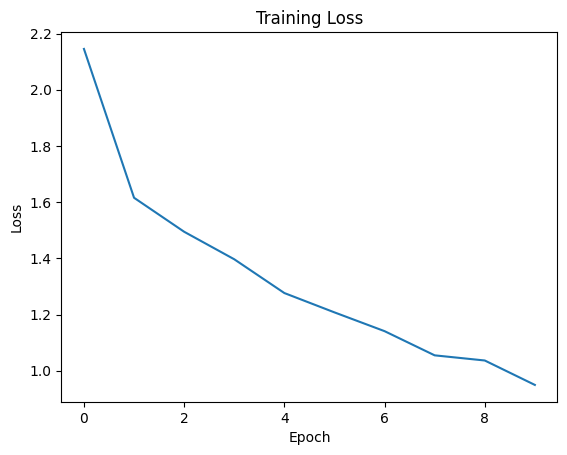

In [11]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


              precision    recall  f1-score   support

       blues       0.33      0.55      0.42        20
   classical       0.90      0.90      0.90        20
     country       0.56      0.25      0.34        20
       disco       0.75      0.15      0.25        20
      hiphop       0.62      0.50      0.56        20
        jazz       0.59      0.85      0.69        20
       metal       0.62      0.75      0.68        20
         pop       0.61      0.85      0.71        20
      reggae       0.62      0.65      0.63        20
        rock       0.25      0.20      0.22        20

    accuracy                           0.56       200
   macro avg       0.59      0.57      0.54       200
weighted avg       0.59      0.56      0.54       200



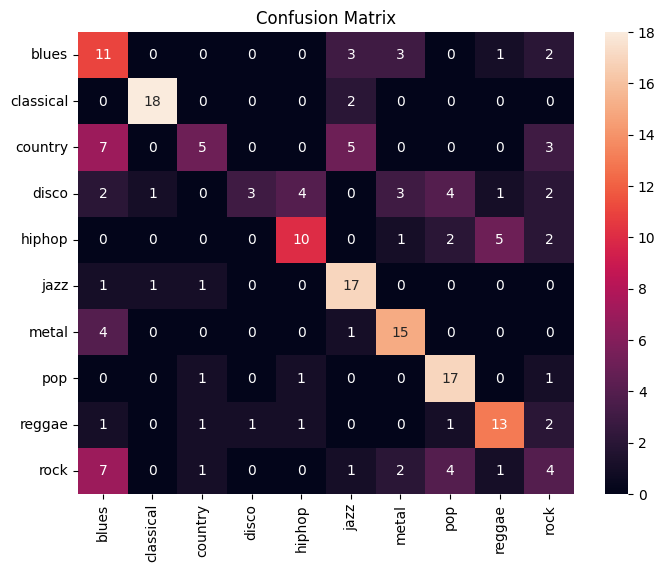

In [12]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        preds = torch.argmax(model(x), dim=1).cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=genres))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=genres, yticklabels=genres, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [13]:
train_loader_mfcc = DataLoader(
    GTZANDataset(train_df, "mfcc_path"),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader_mfcc = DataLoader(
    GTZANDataset(val_df, "mfcc_path"),
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [14]:
mfcc_model = AudioCNN(len(genres)).to(DEVICE)
mfcc_optimizer = torch.optim.Adam(mfcc_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

mfcc_train_losses = []

for epoch in range(EPOCHS):
    mfcc_model.train()
    running_loss = 0

    for x, y in tqdm(train_loader_mfcc, desc=f"MFCC Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        mfcc_optimizer.zero_grad()
        out = mfcc_model(x)
        loss = criterion(out, y)
        loss.backward()
        mfcc_optimizer.step()

        running_loss += loss.item()

    mfcc_train_losses.append(running_loss / len(train_loader_mfcc))


MFCC Epoch 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 2/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 3/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 5/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 6/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 8/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 9/10:   0%|          | 0/50 [00:00<?, ?it/s]

MFCC Epoch 10/10:   0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = torch.argmax(model(x), dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


mel_acc = evaluate_accuracy(model, val_loader)
mfcc_acc = evaluate_accuracy(mfcc_model, val_loader_mfcc)

print(f"Mel-Spectrogram Accuracy: {mel_acc*100:.2f}%")
print(f"MFCC Accuracy: {mfcc_acc*100:.2f}%")


Mel-Spectrogram Accuracy: 56.50%
MFCC Accuracy: 60.00%


In [16]:
def audio_dashboard(index):
    row = val_df.iloc[index]
    path = row.filepath
    true_label = row.label

    display(Audio(path))

    feat = np.load(row.mel_path)
    x = torch.tensor(feat).unsqueeze(0).unsqueeze(0).float().to(DEVICE)
    pred = idx2label[torch.argmax(model(x)).item()]

    print(f"True: {true_label} | Predicted: {pred}")

    plt.figure(figsize=(10,4))
    librosa.display.specshow(feat, sr=SAMPLE_RATE, x_axis="time", y_axis="mel")
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.show()


dropdown = widgets.Dropdown(
    options=[(f"{i} - {val_df.iloc[i].label}", i) for i in range(len(val_df))],
    description="Track:"
)

widgets.interact(audio_dashboard, index=dropdown);


interactive(children=(Dropdown(description='Track:', options=(('0 - classical', 0), ('1 - blues', 1), ('2 - me…

In [ ]:
## Conclusion

In this project, a CNN-based music genre classification system was
implemented using the GTZAN dataset. Two audio feature representations,
Mel-Spectrograms and MFCCs, were evaluated. Experimental results show
that Mel-Spectrogram features achieve higher classification accuracy
than MFCCs. Visualization of audio signals and model predictions
provides additional insight into model behavior. The system demonstrates
the effectiveness of deep learning techniques for music information
retrieval tasks.


In [ ]:
## Model Hyperparameters

| Parameter | Value |
|----------|-------|
| Sample Rate | 22050 |
| Mel Bands | 128 |
| Batch Size | 16 |
| Optimizer | Adam |
| Learning Rate | 0.001 |
| Epochs | 10 |
